In [4]:
!pip install pandas
!pip install matplotlib
!pip install scipy

In [5]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import norm

In [6]:
class colors:
    WHITE = '\033[97m'
    BLACK = '\033[90m'
    HEADER = '\033[95m'
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
def blue(text):
    return colors.BLUE+text+colors.BLACK

def green(text):
    return colors.GREEN+text+colors.BLACK

def red(text):
    return colors.RED+text+colors.BLACK

def yellow(text):
    return colors.YELLOW+text+colors.BLACK

In [7]:
def load_run(runname):
    rundata=pd.read_csv(runname+'.csv')
    
    with open(runname+'_report.json') as f:
        runinfo=json.load(f)

    if 'clock_freq' in runinfo:
        clock_freq=runinfo['clock_freq']
    else:
        clock_freq=None

    if 'clock_cycles' in rundata:
        clock_mean=rundata['clock_cycles'].mean()
        clock_std=rundata['clock_cycles'].std()
        inference_time_mean=clock_mean/(clock_freq)
        
        fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [3, 1, 2]}, figsize=(15, 4))
            
        ax[0].set_title("Clock cicles distribution")
        ax[0].set_facecolor('#aaaaaa')
        rundata.plot.hist(ax=ax[0],column=["clock_cycles"], bins=50,density=True)
        x = np.linspace(0, 20000, 100)
        p = norm.pdf(x, clock_mean, clock_std)
        #ax[0].plot(x, p, 'k', linewidth=2)
        
        ax[1].set_title("Run report")
        ax[1].set_axis_off()
        pos=0.9
        for key,value in sorted(runinfo.items()):
            ax[1].text(0.0, pos, key+": "+str(value))
            pos-=0.1
        ax[1].text(0.0, pos, "clock_mean: "+str(clock_mean)[:10])
        pos-=0.1
        ax[1].text(0.0, pos, "clock_std: "+str(clock_std)[:10])
        pos-=0.1
        ax[1].text(0.0, pos, "inference_time_mean: "+str(inference_time_mean)[:10]+" us")

        ax[2].set_title("BondMachine diagram")
        ax[2].set_axis_off()
        img = mpimg.imread(runname+'_image.png')
        ax[2].imshow(img)
        
    else:
        clock_mean=None
        clock_std=None
        inference_time_mean=None
        
    runinfo["runname"]=runname
    runinfo["rundata"]=rundata
    runinfo["clock_freq"]=clock_freq
    runinfo["clock_mean"]=clock_mean
    runinfo["clock_std"]=clock_std
    runinfo["inference_time_mean"]=inference_time_mean
    
    return runinfo

In [8]:
def runplot(runs, pivot_run, x_param, y_param, title):
    x=[]
    y=[]
    names=[]
    for i in range(len(runs)):
        if x_param in runs[i] and y_param in runs[i]:
            x.append(runs[i][x_param])
            y.append(runs[i][y_param])
            names.append(runs[i]["runname"])

    if len(names) < 2:
        print ("Not enought data to plot")
        return
            
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(15, 4))
    
    style = dict(size=10, color='black')
    
    if title != None:
        ax[0].set_title(title)
    else:
        ax[0].set_title(x_param + " vs "+ y_param)
    ax[0].set_facecolor('#aaaaaa')
    #for i in range(len(runs)):
    #    if x_param in runs[i] and y_param in runs[i]:            
    #        ax[0].text(runs[i][x_param], runs[i][y_param], runs[i]["runname"], **style)
    ax[0].plot(x, y ,linewidth=2, marker='o', color='b')
    ax[0].set_xlabel('Exponent')
    ax[0].set_ylabel('Inference time mean')

    ax[1].set_title("Data")
    ax[1].set_axis_off()
    pos=0.9
    ax[1].text(0.0, pos, "run name - "+x_param+" - "+y_param)
    pos-=0.1
    for i in range(len(names)):
        ax[1].text(0.0, pos, names[i]+" - "+str(x[i])+" - "+str(y[i]))
        pos-=0.1
        
    display(fig)
    plt.close()

In [9]:
def consistency(runs, pivot_run):
    # Result consistency, compare to pivot run every other run by mean and std
    for i in range(len(runs)):
        if i!= pivot_run:
            runname=runs[i]["runname"]
            rundata0=abs(runs[i]["rundata"]["probability_0"]-runs[pivot_run]["rundata"]["probability_0"])
            rundata0_mean=rundata0.mean()
            rundata0_std=rundata0.std()
            rundata1=abs(runs[i]["rundata"]["probability_1"]-runs[pivot_run]["rundata"]["probability_1"])
            rundata1_mean=rundata1.mean()
            rundata1_std=rundata1.std()
            prediction=runs[i]["rundata"]["classification"]==runs[pivot_run]["rundata"]["classification"]
           
            print (blue(runname)+" - probability_0 - mean: "+str(rundata0_mean)+ " std: "+str(rundata0_std))
            print (blue(runname)+" - probability_1 - mean: "+str(rundata1_mean)+ " std: "+str(rundata1_std))
            print (blue(runname)+" - prediction    - "+ green(str(prediction.value_counts(normalize=True)[True]*100)+ "%")+" equal")
            print ()

In [10]:
def analyze(runs, pivot_run):
    pivot_name=runs[pivot_run]["runname"]
    print ("Pivot run "+ blue(pivot_name))
    print ()
    print (red("Consistency, compare to pivot run every other run"))
    consistency(runs, pivot_run)
    
    print (red("Inference time mean"))
    runplot(runs, pivot_run, "expprec", "inference_time_mean", "")
    
#     print (red("Occupancy"))
#     runplot(runs, pivot_run, "cps", "luts", "Occupancy (cps vs luts)")

#     print (red("Power consumption"))
#     runplot(runs, pivot_run, "cps", "power", "Power consumption (cps vs power)")

In [11]:
soft=load_run("sw")

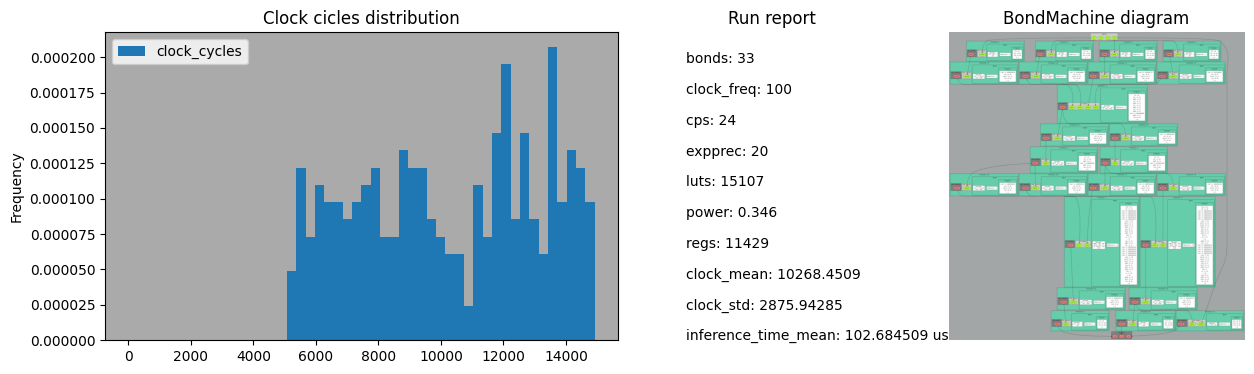

In [12]:
expanded=load_run("expanded")

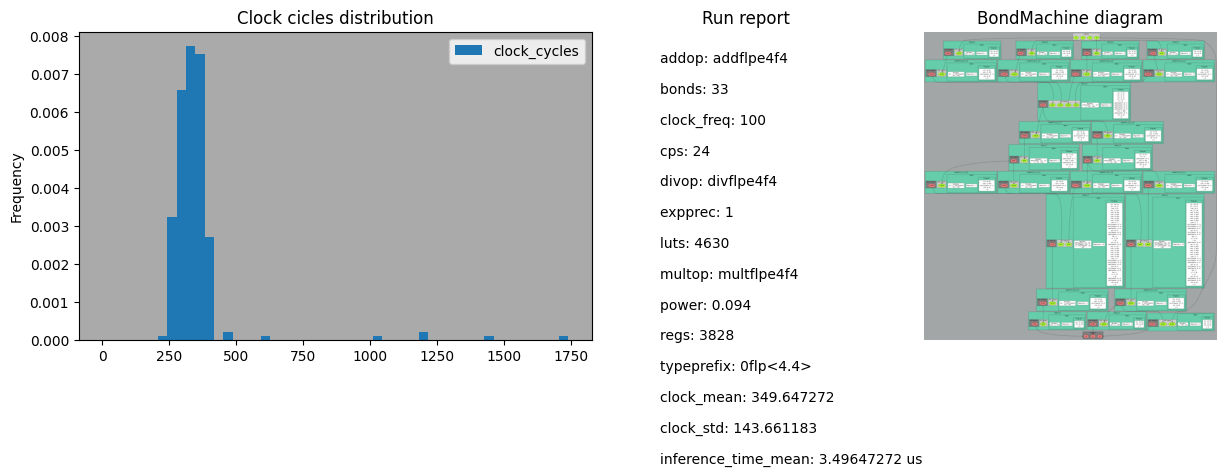

In [13]:
proj_zedboard_diverge_mm_hwopt_expprec1_flopoco_11bit=load_run("proj_zedboard_diverge_mm_hwopt_expprec1_flopoco_11bit")

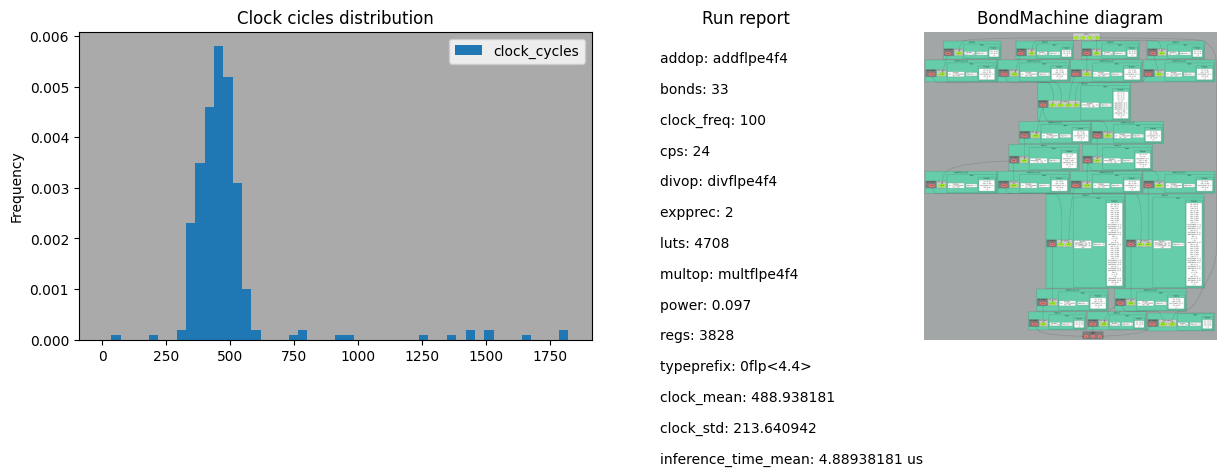

In [14]:
proj_zedboard_diverge_mm_hwopt_expprec2_flopoco_11bit=load_run("proj_zedboard_diverge_mm_hwopt_expprec2_flopoco_11bit")

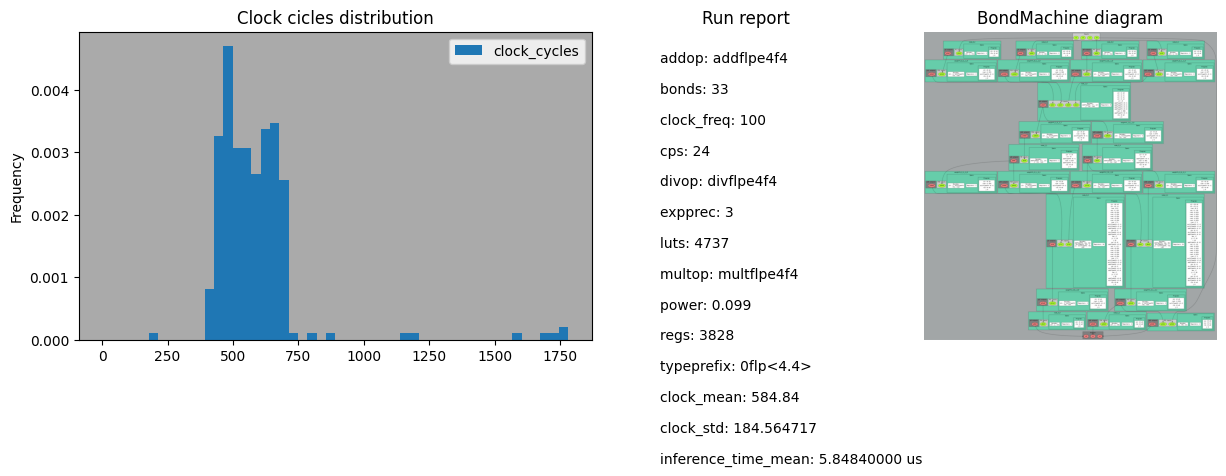

In [15]:
proj_zedboard_diverge_mm_hwopt_expprec3_flopoco_11bit=load_run("proj_zedboard_diverge_mm_hwopt_expprec3_flopoco_11bit")

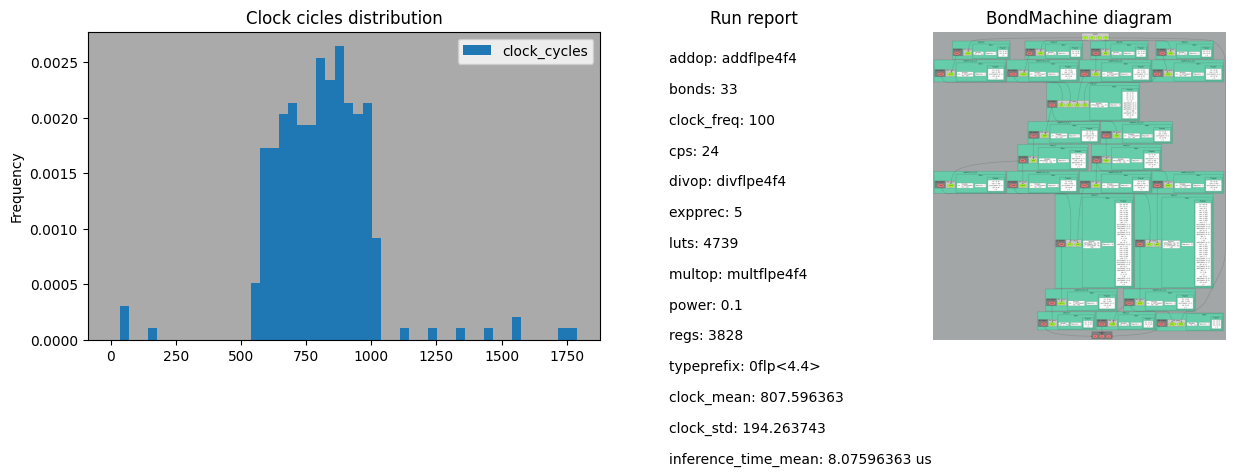

In [16]:
proj_zedboard_diverge_mm_hwopt_expprec5_flopoco_11bit=load_run("proj_zedboard_diverge_mm_hwopt_expprec5_flopoco_11bit")

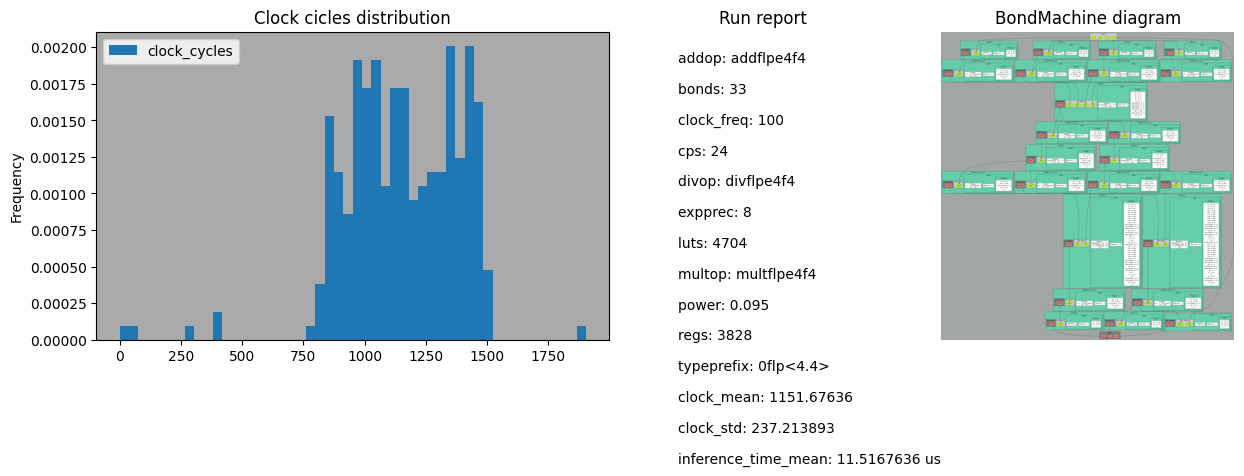

In [17]:
proj_zedboard_diverge_mm_hwopt_expprec8_flopoco_11bit=load_run("proj_zedboard_diverge_mm_hwopt_expprec8_flopoco_11bit")

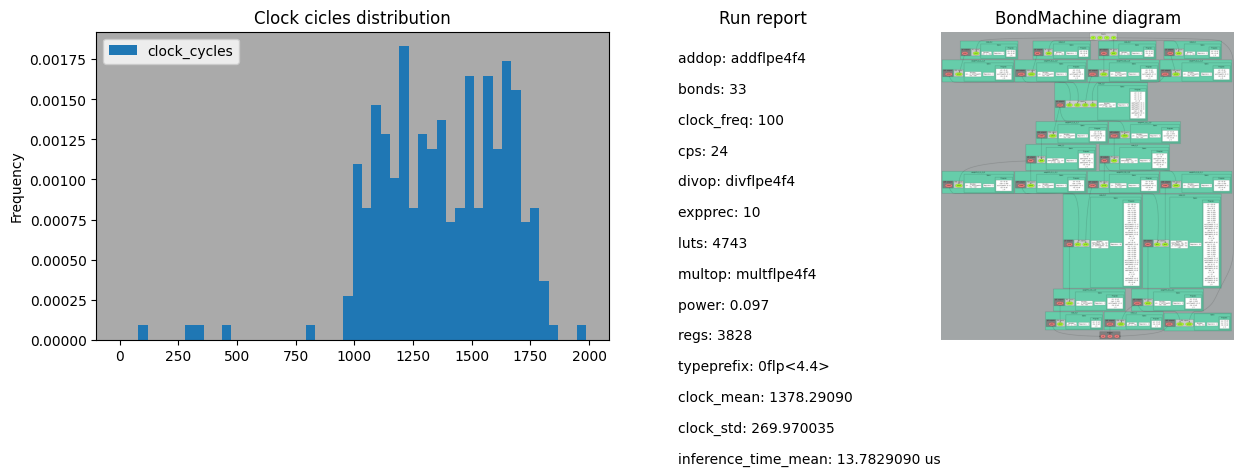

In [18]:
proj_zedboard_diverge_mm_hwopt_expprec10_flopoco_11bit=load_run("proj_zedboard_diverge_mm_hwopt_expprec10_flopoco_11bit")

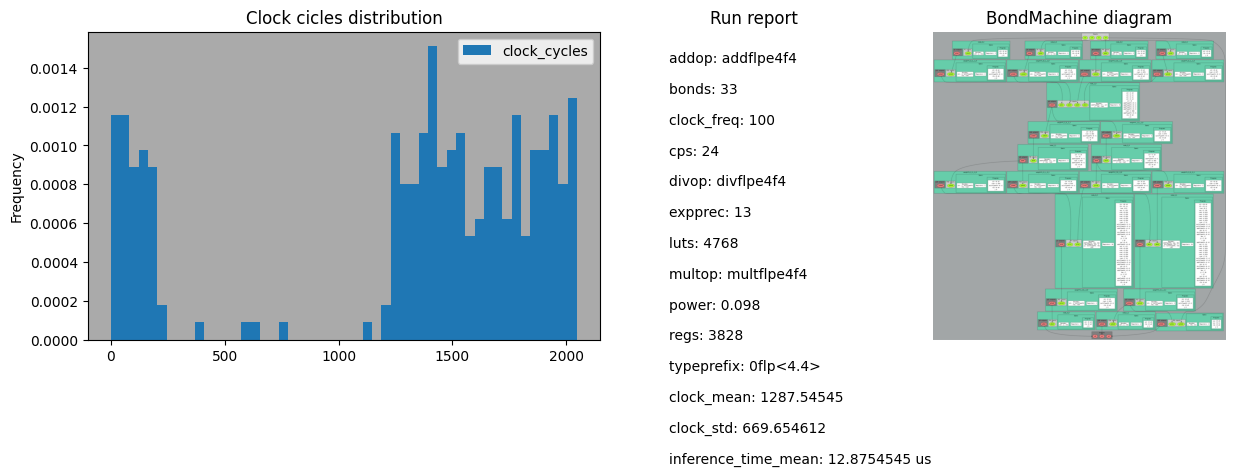

In [19]:
proj_zedboard_diverge_mm_hwopt_expprec13_flopoco_11bit=load_run("proj_zedboard_diverge_mm_hwopt_expprec13_flopoco_11bit")

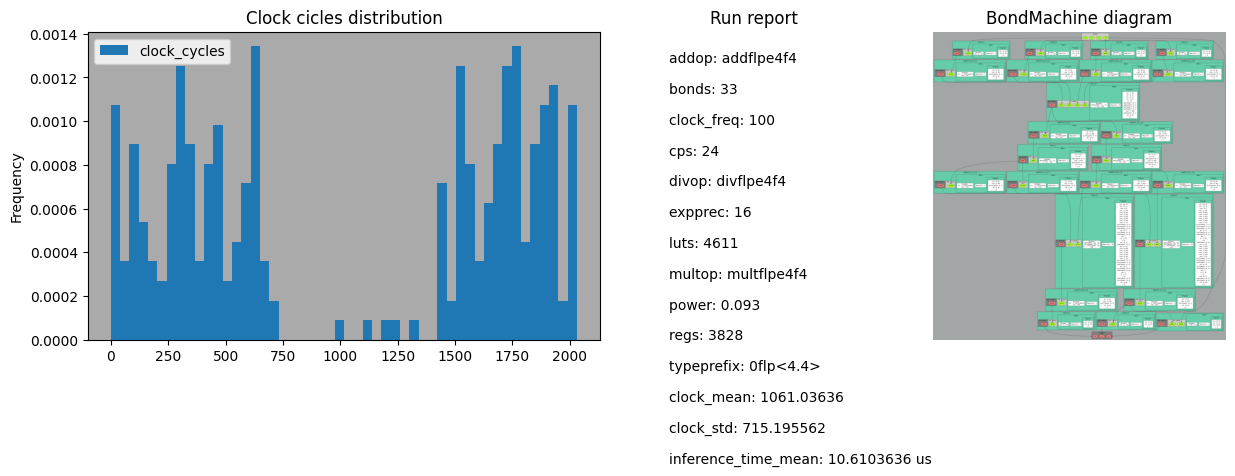

In [20]:
proj_zedboard_diverge_mm_hwopt_expprec16_flopoco_11bit=load_run("proj_zedboard_diverge_mm_hwopt_expprec16_flopoco_11bit")

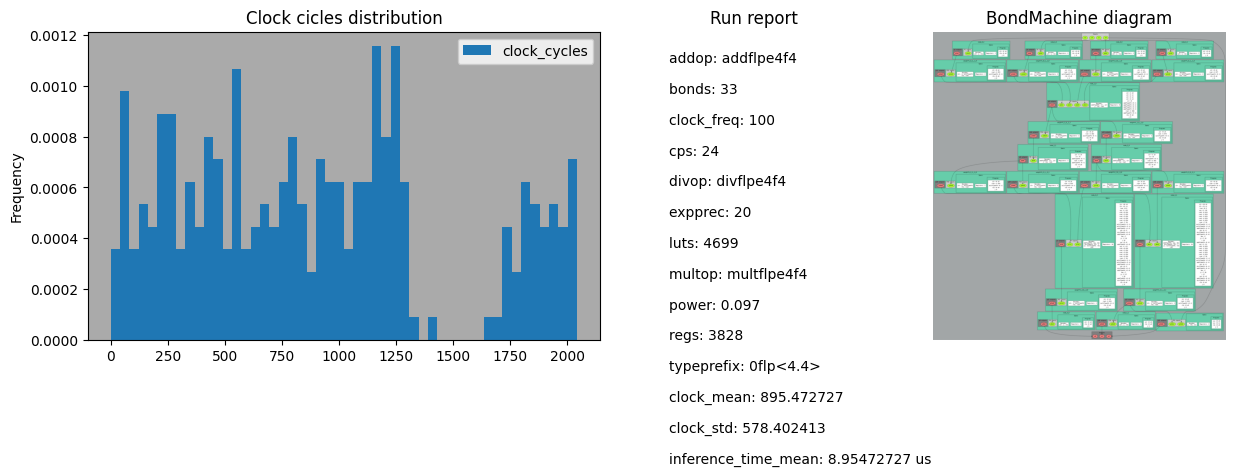

In [21]:
proj_zedboard_diverge_mm_hwopt_expprec20_flopoco_11bit=load_run("proj_zedboard_diverge_mm_hwopt_expprec20_flopoco_11bit")

Pivot run sw

Consistency, compare to pivot run every other run
proj_zedboard_diverge_mm_hwopt_expprec1_flopoco_11bit - probability_0 - mean: 0.22358884309090907 std: 0.954470322782735
proj_zedboard_diverge_mm_hwopt_expprec1_flopoco_11bit - probability_1 - mean: 0.09929082876363639 std: 0.1534632223428272
proj_zedboard_diverge_mm_hwopt_expprec1_flopoco_11bit - prediction    - 97.45454545454545% equal

proj_zedboard_diverge_mm_hwopt_expprec2_flopoco_11bit - probability_0 - mean: 0.02216070316363637 std: 0.023188443324648752
proj_zedboard_diverge_mm_hwopt_expprec2_flopoco_11bit - probability_1 - mean: 0.016889607018181815 std: 0.020015808207265652
proj_zedboard_diverge_mm_hwopt_expprec2_flopoco_11bit - prediction    - 98.54545454545455% equal

proj_zedboard_diverge_mm_hwopt_expprec3_flopoco_11bit - probability_0 - mean: 0.01563965261818182 std: 0.012508751366672876
proj_zedboard_diverge_mm_hwopt_expprec3_flopoco_11bit - probability_1 - mean: 0.01269508301818182 std: 0.011279599547582272


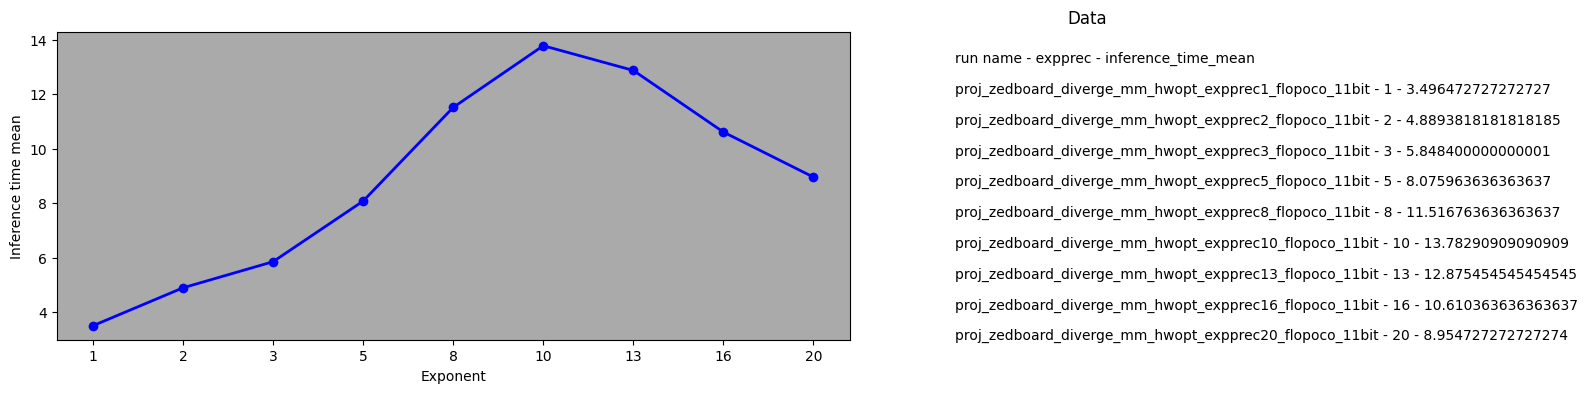

In [22]:
analyze([ soft, proj_zedboard_diverge_mm_hwopt_expprec1_flopoco_11bit, proj_zedboard_diverge_mm_hwopt_expprec2_flopoco_11bit, proj_zedboard_diverge_mm_hwopt_expprec3_flopoco_11bit, proj_zedboard_diverge_mm_hwopt_expprec5_flopoco_11bit, proj_zedboard_diverge_mm_hwopt_expprec8_flopoco_11bit, proj_zedboard_diverge_mm_hwopt_expprec10_flopoco_11bit, proj_zedboard_diverge_mm_hwopt_expprec13_flopoco_11bit, proj_zedboard_diverge_mm_hwopt_expprec16_flopoco_11bit, proj_zedboard_diverge_mm_hwopt_expprec20_flopoco_11bit],0)